In [1]:
import datetime as dt
from pathlib import Path
import os
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [2]:
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose/data/') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data.head()

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103


In [3]:
data["Time"] = pd.to_datetime(data["Time"], unit= "s")
data

,UserId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
27,1,1721,4,2000-12-31 22:00:55
37,1,1022,5,2000-12-31 22:00:55
24,1,2340,3,2000-12-31 22:01:43
...,...,...,...,...
1000019,6040,2917,4,2001-08-10 14:40:29
999988,6040,1921,4,2001-08-10 14:41:04
1000172,6040,1784,3,2001-08-10 14:41:04
1000167,6040,161,3,2001-08-10 14:41:26


## 데이터 전처리

In [4]:
data['UserId'].nunique(), data['ItemId'].nunique()

(6040, 3706)

In [5]:
# 세션별 클릭수
userid_length = data.groupby('UserId').size()
userid_length

UserId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

In [6]:
oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest) 
print(latest)
type(latest)

2000-04-25 23:05:32
2003-02-28 17:49:50


pandas._libs.tslibs.timestamps.Timestamp

In [7]:
userid_length.median(), userid_length.mean()

(96.0, 165.5975165562914)

In [8]:
userid_length.min(), userid_length.max()

(20, 2314)

In [9]:
userid_length.quantile(0.999)

1343.181000000005

In [10]:
long_userid = userid_length[userid_length==2314].index[0]
data[data['UserId']==long_userid]

,UserId,ItemId,Rating,Time
696969,4169,1268,5,2000-08-03 20:09:52
697168,4169,2617,4,2000-08-03 20:09:52
697185,4169,2628,4,2000-08-03 20:09:52
697219,4169,2653,4,2000-08-03 20:09:52
697275,4169,423,3,2000-08-03 20:09:52
...,...,...,...,...
697882,4169,3754,2,2002-06-15 20:52:27
695702,4169,1413,3,2002-06-15 21:03:51
697358,4169,494,4,2002-06-15 21:16:00
695945,4169,1804,2,2002-06-15 21:16:23


In [11]:
length_count = userid_length.groupby(userid_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.99]
length_percent_cumsum_999

20     0.014238
21     0.029305
22     0.042053
23     0.055464
24     0.068874
         ...   
888    0.989073
893    0.989404
894    0.989570
900    0.989735
903    0.989901
Length: 684, dtype: float64

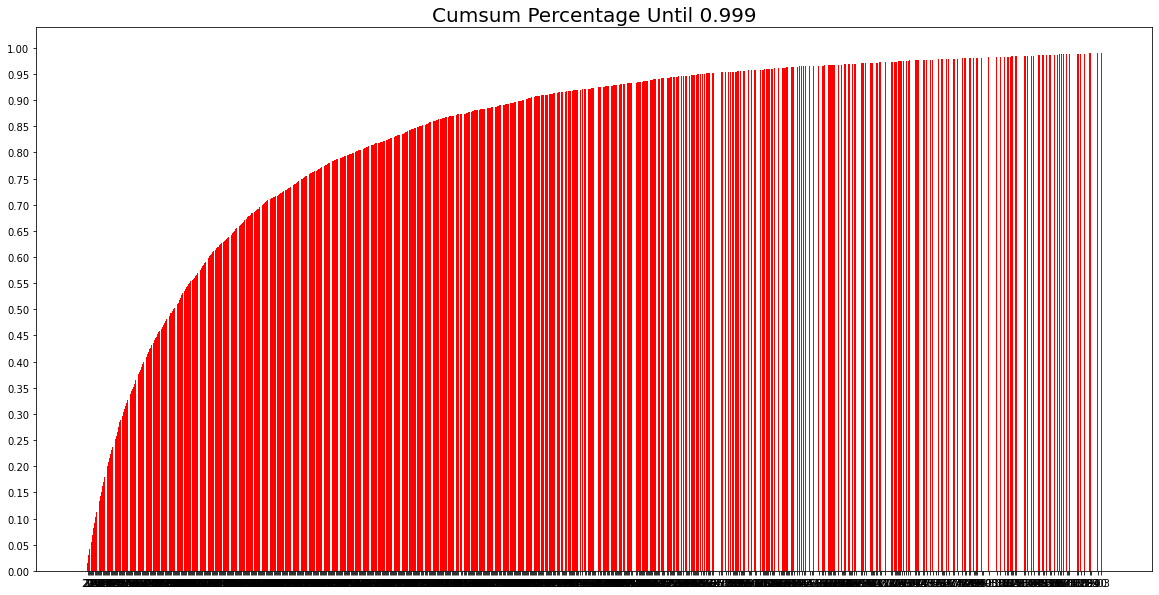

In [12]:
# 세션 길이 기준 하위 99.9%까지의 분포 누적합을 시각화
plt.figure(figsize=(20, 10))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='red')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

In [13]:
oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest) 
print(latest)
type(latest)

2000-04-25 23:05:32
2003-02-28 17:49:50


pandas._libs.tslibs.timestamps.Timestamp

In [14]:
type(latest)

pandas._libs.tslibs.timestamps.Timestamp

In [15]:
# short_session을 제거한 다음 unpopular item을 제거하면 다시 길이가 1인 session이 생길 수 있습니다.
# 이를 위해 반복문을 통해 지속적으로 제거 합니다.
def cleanse_recursive(data: pd.DataFrame, shortest, least_click) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_user(data, shortest)
        data = cleanse_unpopular_item(data, least_click)
        after_len = len(data)
        if before_len == after_len:
            break
    return data


def cleanse_short_user(data: pd.DataFrame, shortest):
    user_len = data.groupby('UserId').size()
    user_use = user_len[user_len >= shortest].index
    data = data[data['UserId'].isin(user_use)]
    return data


def cleanse_unpopular_item(data: pd.DataFrame, least_click):
    item_popular = data.groupby('ItemId').size()
    item_use = item_popular[item_popular >= least_click].index
    data = data[data['ItemId'].isin(item_use)]
    return data

In [16]:
data = cleanse_recursive(data, shortest=2, least_click=5)
data

,UserId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
27,1,1721,4,2000-12-31 22:00:55
37,1,1022,5,2000-12-31 22:00:55
24,1,2340,3,2000-12-31 22:01:43
...,...,...,...,...
1000019,6040,2917,4,2001-08-10 14:40:29
999988,6040,1921,4,2001-08-10 14:41:04
1000172,6040,1784,3,2001-08-10 14:41:04
1000167,6040,161,3,2001-08-10 14:41:26


In [17]:
#가장 오래된 데이터와 가장 최신의 데이터를 알아보기위해 time순으로 정렬
data = data.sort_values(by=['Time'])
data

,UserId,ItemId,Rating,Time
1000138,6040,858,4,2000-04-25 23:05:32
999873,6040,593,5,2000-04-25 23:05:54
1000153,6040,2384,4,2000-04-25 23:05:54
1000007,6040,1961,4,2000-04-25 23:06:17
1000192,6040,2019,5,2000-04-25 23:06:17
...,...,...,...,...
825793,4958,2399,1,2003-02-28 17:45:38
825438,4958,1407,5,2003-02-28 17:47:23
825724,4958,3264,4,2003-02-28 17:49:08
825731,4958,2634,3,2003-02-28 17:49:08


In [18]:
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['Time'].max()
    user_last_time = data.groupby('UserId')['Time'].max().sort_values()
    user_in_train = data[data['Time'] < final_time - dt.timedelta(n_days)]
    user_in_test = data[data['Time'] >= final_time - dt.timedelta(n_days)]
    
    before_date = user_in_train
    after_date = user_in_test
    return before_date, after_date

In [19]:
# 180일씩 split 
tr, test = split_by_date(data, n_days=180)
tr, val = split_by_date(tr, n_days=180)

In [20]:
# data에 대한 정보를 살펴봅니다.
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Users: {data["UserId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

In [21]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 978534
	 Users: 6038
	 Items: 3416
	 First Time : 2000-04-25 23:05:32
	 Last Time : 2002-03-05 04:19:56

* valid Set Stats Info
	 Events: 12271
	 Users: 399
	 Items: 2606
	 First Time : 2002-03-05 04:21:07
	 Last Time : 2002-09-01 04:20:59

* test Set Stats Info
	 Events: 8806
	 Users: 339
	 Items: 2317
	 First Time : 2002-09-01 19:41:39
	 Last Time : 2003-02-28 17:49:50



In [22]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

In [23]:
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

## 미니배치 구성

In [24]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['UserId'].nunique())  # indexing to SessionId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['UserId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('UserId').size().cumsum()
        return offsets

In [25]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

,UserId,ItemId,Rating,Time,item_idx
1000138,6040,858,4,2000-04-25 23:05:32,0
999873,6040,593,5,2000-04-25 23:05:54,1
1000153,6040,2384,4,2000-04-25 23:05:54,2
1000007,6040,1961,4,2000-04-25 23:06:17,3
1000192,6040,2019,5,2000-04-25 23:06:17,4
999868,6040,573,4,2000-04-25 23:07:36,5
999877,6040,1419,3,2000-04-25 23:07:36,6
999920,6040,213,5,2000-04-25 23:07:36,7
999967,6040,3111,5,2000-04-25 23:07:36,8
999980,6040,3505,4,2000-04-25 23:07:36,9


In [26]:
tr_dataset.click_offsets

array([     0,     53,    182, ..., 978070, 978193, 978534], dtype=int32)

In [27]:
tr_dataset.session_idx

array([   0,    1,    2, ..., 6035, 6036, 6037])

In [28]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [29]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(15)

,UserId,ItemId,Rating,Time,item_idx
1000138,6040,858,4,2000-04-25 23:05:32,0
999873,6040,593,5,2000-04-25 23:05:54,1
1000153,6040,2384,4,2000-04-25 23:05:54,2
1000007,6040,1961,4,2000-04-25 23:06:17,3
1000192,6040,2019,5,2000-04-25 23:06:17,4
999868,6040,573,4,2000-04-25 23:07:36,5
999877,6040,1419,3,2000-04-25 23:07:36,6
999920,6040,213,5,2000-04-25 23:07:36,7
999967,6040,3111,5,2000-04-25 23:07:36,8
999980,6040,3505,4,2000-04-25 23:07:36,9


In [30]:
iter_ex = iter(tr_data_loader)

In [31]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [  0  53 177 210]
Label Item Idx are :       [  1  54 106 211]
Previous Masked Input Idx are []


## 모델구성

In [32]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

In [33]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [34]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [35]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['UserId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

## 모델학습

In [36]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['UserId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['UserId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

## 모델테스트

In [38]:
# 첫번재 테스트
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

In [39]:
args1 = Args(tr, val, test, batch_size=256, hsz=50, drop_rate=0.1, lr=0.001, epochs=5, k=20)
model1 = create_model(args1)
train_model(model1, args1)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(256, 1, 3416)]          0         
_________________________________________________________________
GRU (GRU)                    [(256, 50), (256, 50)]    520200    
_________________________________________________________________
dropout (Dropout)            (256, 50)                 0         
_________________________________________________________________
dense (Dense)                (256, 3416)               174216    
Total params: 694,416
Trainable params: 694,416
Non-trainable params: 0
_________________________________________________________________


Evaluation:  15%|█▌        | 7/46 [00:07<00:43,  1.10s/it]


	 - Recall@20 epoch 1: 0.046875
	 - MRR@20    epoch 1: 0.011213



Evaluation:  15%|█▌        | 7/46 [00:07<00:41,  1.05s/it]


	 - Recall@20 epoch 2: 0.064732
	 - MRR@20    epoch 2: 0.014594



Evaluation:  15%|█▌        | 7/46 [00:07<00:40,  1.03s/it]


	 - Recall@20 epoch 3: 0.075335
	 - MRR@20    epoch 3: 0.017679



Evaluation:  15%|█▌        | 7/46 [00:07<00:40,  1.03s/it]


	 - Recall@20 epoch 4: 0.079241
	 - MRR@20    epoch 4: 0.018709



Evaluation:  15%|█▌        | 7/46 [00:07<00:39,  1.02s/it]

	 - Recall@20 epoch 5: 0.085938
	 - MRR@20    epoch 5: 0.019657



In [41]:
# 첫번째테스트에서 학습횟수만늘림
args2 = Args(tr, val, test, batch_size=256, hsz=50, drop_rate=0.1, lr=0.001, epochs=10, k=20)
model2 = create_model(args2)
train_model(model2, args2)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(256, 1, 3416)]          0         
_________________________________________________________________
GRU (GRU)                    [(256, 50), (256, 50)]    520200    
_________________________________________________________________
dropout_2 (Dropout)          (256, 50)                 0         
_________________________________________________________________
dense_2 (Dense)              (256, 3416)               174216    
Total params: 694,416
Trainable params: 694,416
Non-trainable params: 0
_________________________________________________________________


Evaluation:  15%|█▌        | 7/46 [00:07<00:41,  1.06s/it]


	 - Recall@20 epoch 1: 0.046875
	 - MRR@20    epoch 1: 0.009684



Evaluation:  15%|█▌        | 7/46 [00:07<00:39,  1.02s/it]


	 - Recall@20 epoch 2: 0.077567
	 - MRR@20    epoch 2: 0.017965



Evaluation:  15%|█▌        | 7/46 [00:07<00:39,  1.02s/it]


	 - Recall@20 epoch 3: 0.093192
	 - MRR@20    epoch 3: 0.020226



Evaluation:  15%|█▌        | 7/46 [00:07<00:39,  1.01s/it]


	 - Recall@20 epoch 4: 0.092634
	 - MRR@20    epoch 4: 0.019600



Evaluation:  15%|█▌        | 7/46 [00:07<00:39,  1.02s/it]


	 - Recall@20 epoch 5: 0.095424
	 - MRR@20    epoch 5: 0.020793



Evaluation:  15%|█▌        | 7/46 [00:07<00:39,  1.00s/it]


	 - Recall@20 epoch 6: 0.096540
	 - MRR@20    epoch 6: 0.022261



Evaluation:  15%|█▌        | 7/46 [00:06<00:38,  1.00it/s]


	 - Recall@20 epoch 7: 0.095982
	 - MRR@20    epoch 7: 0.023017



Evaluation:  15%|█▌        | 7/46 [00:07<00:39,  1.02s/it]


	 - Recall@20 epoch 8: 0.096540
	 - MRR@20    epoch 8: 0.023764



Evaluation:  15%|█▌        | 7/46 [00:07<00:39,  1.00s/it]


	 - Recall@20 epoch 9: 0.096540
	 - MRR@20    epoch 9: 0.024523



Evaluation:  15%|█▌        | 7/46 [00:07<00:39,  1.00s/it]

	 - Recall@20 epoch 10: 0.093750
	 - MRR@20    epoch 10: 0.023909



In [42]:
# 배치사이즈와 러닝레이트 변경
args2 = Args(tr, val, test, batch_size=128, hsz=50, drop_rate=0.1, lr=0.01, epochs=5, k=20)
model2 = create_model(args2)
train_model(model2, args2)

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(128, 1, 3416)]          0         
_________________________________________________________________
GRU (GRU)                    [(128, 50), (128, 50)]    520200    
_________________________________________________________________
dropout_3 (Dropout)          (128, 50)                 0         
_________________________________________________________________
dense_3 (Dense)              (128, 3416)               174216    
Total params: 694,416
Trainable params: 694,416
Non-trainable params: 0
_________________________________________________________________


Evaluation:  45%|████▍     | 41/92 [00:21<00:26,  1.90it/s]


	 - Recall@20 epoch 1: 0.103659
	 - MRR@20    epoch 1: 0.025185



Evaluation:  45%|████▍     | 41/92 [00:21<00:26,  1.93it/s]


	 - Recall@20 epoch 2: 0.106517
	 - MRR@20    epoch 2: 0.026672



Evaluation:  45%|████▍     | 41/92 [00:21<00:26,  1.93it/s]


	 - Recall@20 epoch 3: 0.106517
	 - MRR@20    epoch 3: 0.025562



Evaluation:  45%|████▍     | 41/92 [00:21<00:26,  1.91it/s]


	 - Recall@20 epoch 4: 0.102515
	 - MRR@20    epoch 4: 0.024467



Evaluation:  45%|████▍     | 41/92 [00:21<00:26,  1.90it/s]

	 - Recall@20 epoch 5: 0.102706
	 - MRR@20    epoch 5: 0.025695



## 회고
#### 학습횟수만 늘려도 정확도가 생각만큼 올라가지않았다.
#### 하지만 recall과 mrr은 개선되었다
#### 최적의 하이퍼파라미터값을 찾아 쓴다면 높은 정확도를 기대할수있겠다.